In [2]:
import tensorflow as tf

!nvidia-smi  
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tue Feb 18 10:47:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 30.7 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pydot
import graphviz
from matplotlib.image import imread
import cv2
import os

In [22]:
labels = pd.read_csv("/kaggle/input/inbreast/Training_set.csv")
labels.head()

,filename,label
0,Image_1.jpg,Density3Benign
1,Image_2.jpg,Density1Benign
2,Image_3.jpg,Density1Malignant
3,Image_4.jpg,Density1Benign
4,Image_5.jpg,Density1Malignant


In [23]:
file_paths = [[fname, 'train/' + fname] for fname in labels['filename']]

In [24]:
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  5724 matches the number of filenames i.e.  5724


In [25]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,train/Image_1.jpg
1,Image_2.jpg,train/Image_2.jpg
2,Image_3.jpg,train/Image_3.jpg
3,Image_4.jpg,train/Image_4.jpg
4,Image_5.jpg,train/Image_5.jpg


In [21]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,train/Image_1.jpg,Density3Benign
1,Image_2.jpg,train/Image_2.jpg,Density1Benign
2,Image_3.jpg,train/Image_3.jpg,Density1Malignant
3,Image_4.jpg,train/Image_4.jpg,Density1Benign
4,Image_5.jpg,train/Image_5.jpg,Density1Malignant


# EDA

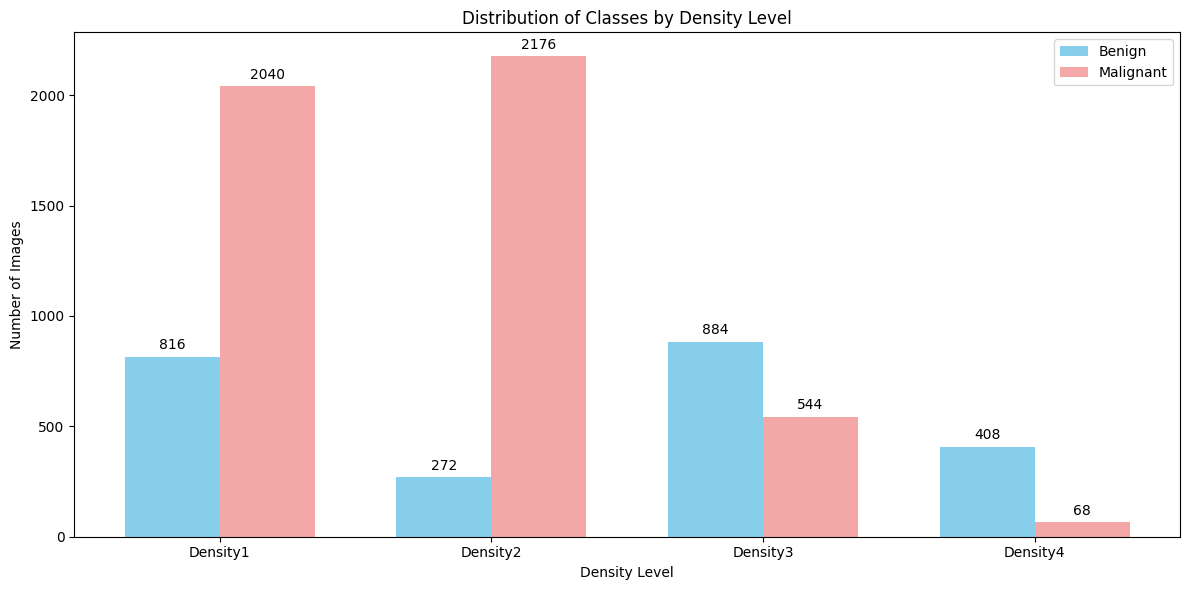

In [19]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Density1', 'Density2', 'Density3', 'Density4']
benign = [816, 272, 884, 408]
malignant = [2040, 2176, 544, 68]

x = np.arange(len(categories))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, benign, width, label='Benign', color='#87CEEB')  # Light blue
rects2 = ax.bar(x + width/2, malignant, width, label='Malignant', color='#F4A7A7')  # Light red

ax.set_ylabel('Number of Images')
ax.set_xlabel('Density Level')
ax.set_title('Distribution of Classes by Density Level')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Adjust layout
plt.tight_layout()

plt.show()

In [26]:
base_path = '/kaggle/input/inbreast'
train_data['filepaths'] = train_data['filepaths'].apply(lambda x: os.path.join(base_path, 'mamog', 'train', os.path.basename(x)))

print("New path:", train_data['filepaths'][0])
print("File exists:", os.path.exists(train_data['filepaths'][0]))

New path: /kaggle/input/inbreast/mamog/train/Image_1.jpg
File exists: True


In [27]:
first_image = train_data['filepaths'][0]

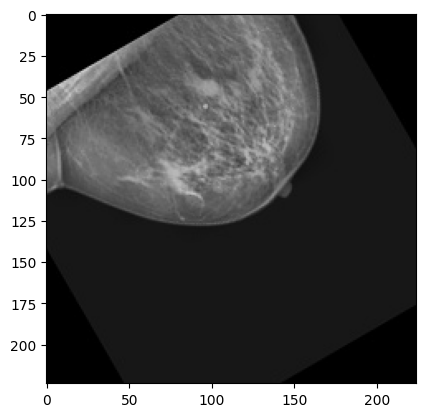

In [28]:
plt.imshow(imread(first_image))

In [29]:
dim1 = []
dim2 = []

for i in range(len(train_data)):
    img = imread(train_data['filepaths'][i])
    d1,d2,color = img.shape
    dim1.append(d1)
    dim2.append(d2)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


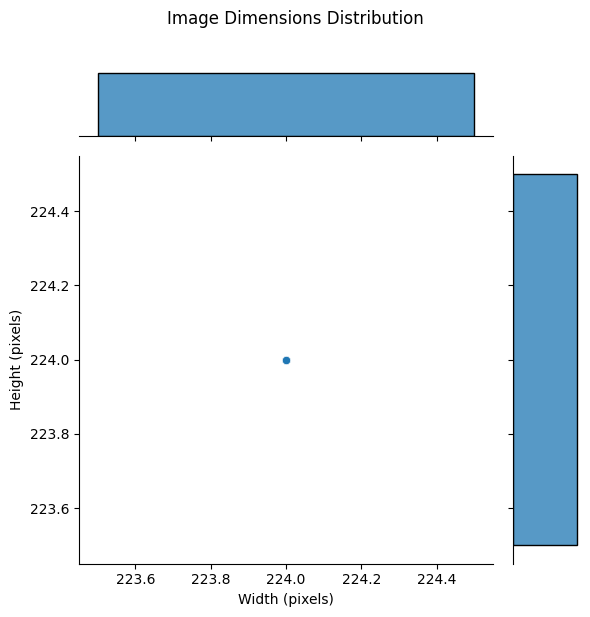

In [30]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'Height': dim1,
    'Width': dim2
})

g = sns.jointplot(
    data=df,
    x='Width',
    y='Height',
    kind='scatter'
)

# Add labels and title
g.fig.suptitle('Image Dimensions Distribution', y=1.02)
g.ax_joint.set_xlabel('Width (pixels)')
g.ax_joint.set_ylabel('Height (pixels)')

plt.tight_layout()
plt.show()

In [31]:
data = []
image_size = 224
for i in range(len(train_data)):

    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, (image_size, image_size))
    if train_data['label'][i] == 'Density1Benign':
        data.append([new_img_array, 0])
    elif train_data['label'][i] == 'Density1Malignant':
        data.append([new_img_array, 1])
    elif train_data['label'][i] == 'Density2Benign':
        data.append([new_img_array, 2])
    elif train_data['label'][i] == 'Density2Malignant':
        data.append([new_img_array, 3])
    elif train_data['label'][i] == 'Density3Benign':
        data.append([new_img_array, 4])
    elif train_data['label'][i] == 'Density3Malignant':
        data.append([new_img_array, 5])
    elif train_data['label'][i] == 'Density4Benign':
        data.append([new_img_array, 6])
    elif train_data['label'][i] == 'Density4Malignant':
        data.append([new_img_array, 7])

In [32]:
data[0]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 4]

In [33]:
np.random.shuffle(data)

In [34]:
x = []
y = []
for image in data:
    x.append(image[0])
    y.append(image[1])

x = np.array(x)
y = np.array(y)

In [35]:
x = x.reshape(x.shape[0], 224, 224, 1)

In [36]:
x.shape

(5724, 224, 224, 1)

In [37]:
image_shape = (224, 224, 1)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.20, random_state = 42)

In [41]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=image_shape, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  


model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))  
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  

model.add(Flatten())
model.add(Dense(128, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=5e-4),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,483,336 (196.39 MB)

 Trainable params: 51,482,568 (196.39 MB)

 Non-trainable params: 768 (3.00 KB)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


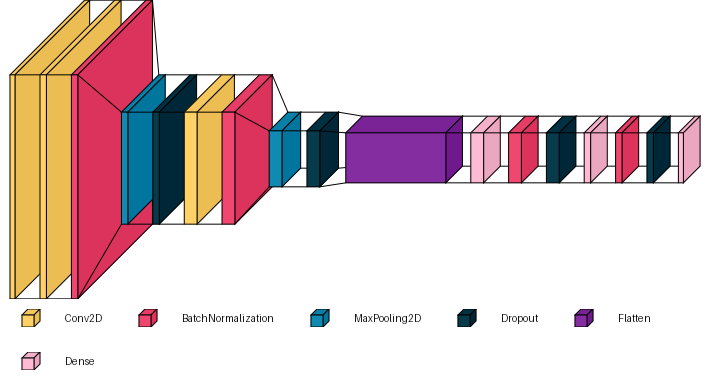

In [43]:
import visualkeras
from tensorflow.keras.utils import plot_model

# First, let's create a text-based visualization
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Then create a more detailed layered visualization using visualkeras
visualkeras.layered_view(model,
                        to_file='model_layered_view.png',
                        legend=True,
                        draw_volume=True,
                        spacing=25,
                        scale_z=0.1,    
                        scale_xy=1,
                        min_z=5,       
                        min_xy=50,
                        max_z=100,      
                        color_map={
                            'Conv2D': '#FFA07A', 
                            'MaxPooling2D': '#98FB98', 
                            'BatchNormalization': '#87CEFA', 
                            'Dropout': '#DDA0DD',  
                            'Dense': '#F0E68C',  
                            'Flatten': '#FFB6C1'  
                        })

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=image_shape, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  


model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))  
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  

model.add(Flatten())
model.add(Dense(128, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=5e-4),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Рассчитываем веса классов
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

# Создаем словарь весов
class_weight_dict = dict(zip(unique_classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.1245088408644401, 1: 0.4346051632498102, 2: 3.4900914634146343, 3: 0.41901537335285505, 4: 1.0059314586994728, 5: 1.654263005780347, 6: 2.1599056603773583, 7: 13.311046511627907}


In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,  # уменьшим batch size
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.1388 - loss: 2.7100 - val_accuracy: 0.1345 - val_loss: 2.2470 - learning_rate: 5.0000e-04
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1540 - loss: 2.3017 - val_accuracy: 0.0664 - val_loss: 2.3995 - learning_rate: 5.0000e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1760 - loss: 1.9751 - val_accuracy: 0.0550 - val_loss: 2.8882 - learning_rate: 5.0000e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.2047 - loss: 1.7646 - val_accuracy: 0.1825 - val_loss: 2.0350 - learning_rate: 5.0000e-04
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.2570 - loss: 1.6020 - val_accuracy: 0.1878 - val_loss: 2.0903 - learning_rate: 5.0000e-04
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.3172 - loss: 1.3823 - val_accuracy: 0.2611 - val_loss: 1.8454 - learning_rate: 5.0000e-04
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [46]:
# early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [47]:
# model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_val, y_val), callbacks = [early_stop])

In [48]:
metrics = pd.DataFrame(model.history.history)

<Axes: >

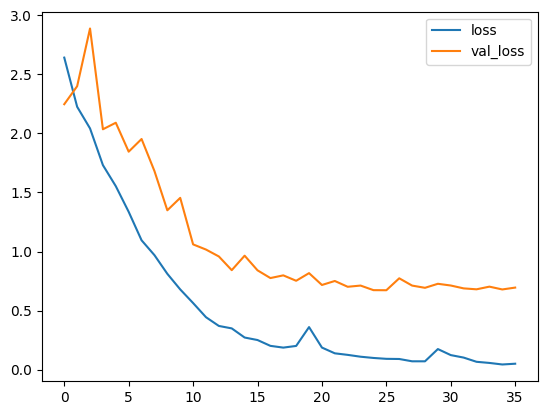

In [49]:
metrics[['loss', 'val_loss']].plot()

<Axes: >

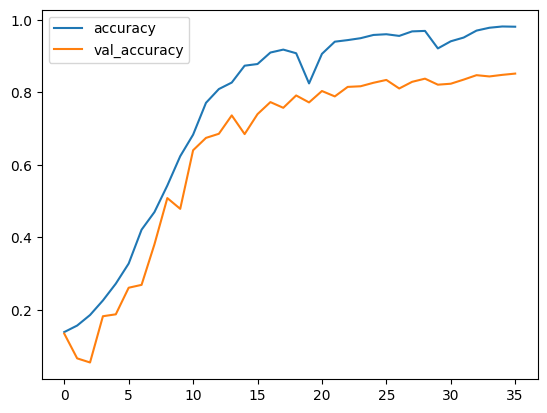

In [50]:
metrics[['accuracy', 'val_accuracy']].plot()

In [51]:
model.evaluate(X_val, y_val)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8494 - loss: 0.6219


[0.6725857257843018, 0.8340611457824707]

In [52]:
# Получаем предсказания модели
y_pred = model.predict(X_val)

# Конвертируем в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)

# Если y_val в one-hot формате, конвертируем в метки классов
if len(y_val.shape) > 1:  # проверяем, является ли y_val one-hot encoded
    y_true_classes = np.argmax(y_val, axis=1)
else:
    y_true_classes = y_val

# Расчет F1-score
from sklearn.metrics import f1_score, classification_report

# Для каждого типа усреднения
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Macro F1-score: {f1_macro:.3f}")
print(f"Weighted F1-score: {f1_weighted:.3f}")

# Детальный отчет по всем классам
class_names = ['Density1Benign', 'Density1Malignant', 
               'Density2Benign', 'Density2Malignant',
               'Density3Benign', 'Density3Malignant',
               'Density4Benign', 'Density4Malignant']

print("\nDetailed classification report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Macro F1-score: 0.805
Weighted F1-score: 0.835

Detailed classification report:
                   precision    recall  f1-score   support

   Density1Benign       0.85      0.76      0.80       139
Density1Malignant       0.81      0.86      0.83       303
   Density2Benign       0.85      0.90      0.88        52
Density2Malignant       0.88      0.83      0.85       362
   Density3Benign       0.86      0.86      0.86       133
Density3Malignant       0.87      0.79      0.83        86
   Density4Benign       0.63      0.90      0.74        59
Density4Malignant       0.64      0.64      0.64        11

         accuracy                           0.83      1145
        macro avg       0.80      0.82      0.81      1145
     weighted avg       0.84      0.83      0.83      1145



In [74]:
from tensorflow.keras.models import load_model, save_model

In [53]:
classes = {0 : 'Density1Benign' ,
1 : 'Density1Malignant',
2: 'Density2Benign',
3 : 'Density2Malignant',
4 : 'Density3Benign',
5 : 'Density3Malignant',
6 : 'Density4Benign',
7 : 'Density4Malignant'}

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


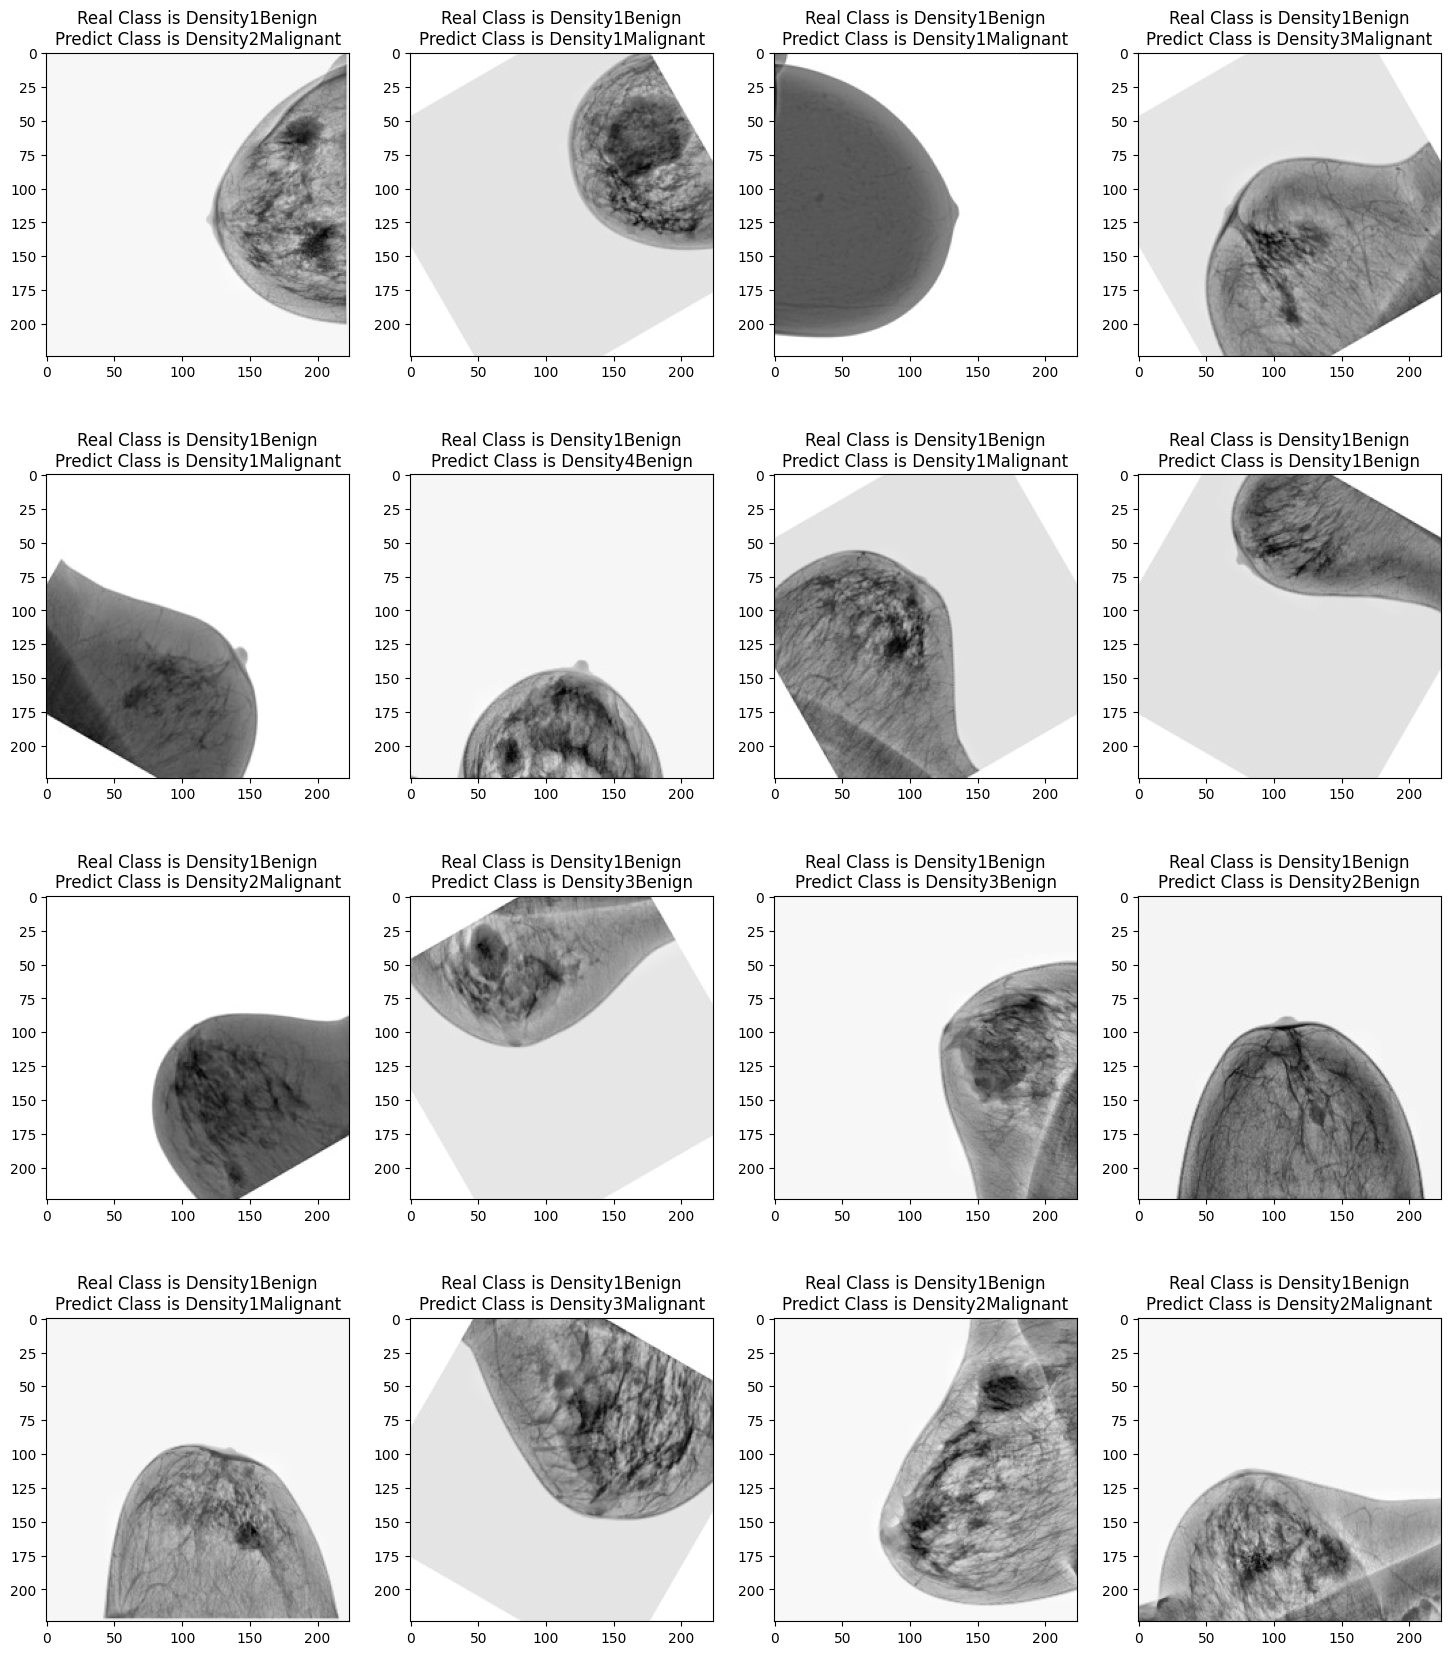

In [55]:
y_pred = model.predict(X_val)
X_test__ = X_val.reshape(X_val.shape[0], 224, 224)

fig, axis = plt.subplots(4, 4, figsize=(18, 21))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Class is {classes[y_val[i].argmax()]}\nPredict Class is {classes[y_pred[i].argmax()]}");

In [66]:
print("y_val shape:", y_val.shape)
print("y_pred shape:", y_pred.shape)
print("\nUnique values in y_val:", np.unique(y_val))
print("Unique values in y_pred:", np.unique(y_pred))

# Check the data types
print("\ny_val dtype:", y_val.dtype)
print("y_pred dtype:", y_pred.dtype)

# Check if either is continuous
print("\nIs y_val continuous?", np.any(y_val % 1 != 0))
print("Is y_pred continuous?", np.any(y_pred % 1 != 0))

# Print a few examples
print("\nFirst few y_val samples:", y_val[:5])
print("First few y_pred samples:", y_pred[:5])

y_val shape: (1145,)
y_pred shape: (1145, 8)

Unique values in y_val: [0 1 2 3 4 5 6 7]
Unique values in y_pred: [2.7367641e-11 1.3922234e-10 1.4422182e-10 ... 9.9992228e-01 9.9997687e-01
 9.9999928e-01]

y_val dtype: int64
y_pred dtype: float32

Is y_val continuous? False
Is y_pred continuous? True

First few y_val samples: [1 6 0 3 3]
First few y_pred samples: [[5.38505279e-02 5.37028372e-01 1.47192795e-02 3.35593611e-01
  1.54397013e-02 3.91672552e-03 2.10205689e-02 1.84311718e-02]
 [6.01730600e-04 9.97260690e-01 2.33708226e-04 4.39625932e-04
  4.85950935e-04 1.74348650e-04 7.53964414e-04 4.99282905e-05]
 [9.19312984e-02 8.66235018e-01 1.05718535e-03 1.26116043e-02
  1.06637217e-02 1.42025892e-02 2.37083249e-03 9.27694491e-04]
 [9.04751942e-04 3.15736892e-04 1.91178848e-03 9.70677078e-01
  1.46368816e-02 9.28604743e-04 9.16233053e-04 9.70885437e-03]
 [8.43208730e-01 1.08112141e-01 5.40265255e-03 1.75668467e-02
  3.99680436e-03 1.63829664e-03 8.75434652e-03 1.13202352e-02]]


In [67]:
import numpy as np

# Convert probability predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now create confusion matrix with the class labels
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes))

Confusion Matrix:
[[108   8   0   6   1   0   0   0]
 [  2 260   1  19  13   2  19   0]
 [  1   1  38   3   4   0   0   0]
 [ 12  17   0 283   7   0   7   1]
 [  0   0   1   9 139   1   5   0]
 [  2   3   0   5   1  82   1   0]
 [  1   4   0   0   0   0  62   0]
 [  0   0   0   3   0   0   0  13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       123
           1       0.89      0.82      0.85       316
           2       0.95      0.81      0.87        47
           3       0.86      0.87      0.86       327
           4       0.84      0.90      0.87       155
           5       0.96      0.87      0.92        94
           6       0.66      0.93      0.77        67
           7       0.93      0.81      0.87        16

    accuracy                           0.86      1145
   macro avg       0.87      0.86      0.86      1145
weighted avg       0.87      0.86      0.86      1145



In [50]:
# !pip install tensorflow-addons

In [53]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input
from tensorflow.keras.regularizers import l1_l2

# Создаем модель с явным указанием Input
inputs = Input(shape=image_shape)

# Первый блок свёрточных слоев
x = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu',
           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)
x = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu',
           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Dropout(0.5)(x)

# Второй блок
x = Conv2D(128, kernel_size=(3,3), padding='same', activation='relu',
           kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Dropout(0.5)(x)

# Полносвязные слои
x = Flatten()(x)
x = Dense(128, activation='relu', 
          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
          activity_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',
          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
          activity_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Компилируем модель
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Обучаем модель
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.2,
            patience=7,
            min_lr=1e-6
        )
    ]
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 240ms/step - accuracy: 0.1243 - loss: 5.9152 - val_accuracy: 0.0934 - val_loss: 92.2158 - learning_rate: 5.0000e-04
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1323 - loss: 3.6008 - val_accuracy: 0.1214 - val_loss: 829.0468 - learning_rate: 5.0000e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1267 - loss: 3.3604 - val_accuracy: 0.0769 - val_loss: 1453.3719 - learning_rate: 5.0000e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1308 - loss: 3.2202 - val_accuracy: 0.0961 - val_loss: 1811.2921 - learning_rate: 5.0000e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1230 - loss: 3.0478 - val_accuracy: 0.1432 - val_loss: 1246.9261 - learning_rate: 5.0000e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1111 - loss: 2.8477 - val_accuracy: 0.1380 - val_loss: 1837.3289 - learning_rate: 5.0000e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━

In [54]:
# Получаем предсказания модели
y_pred = model.predict(X_val)

# Конвертируем в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)

# Если y_val в one-hot формате, конвертируем в метки классов
if len(y_val.shape) > 1:  # проверяем, является ли y_val one-hot encoded
    y_true_classes = np.argmax(y_val, axis=1)
else:
    y_true_classes = y_val

# Расчет F1-score
from sklearn.metrics import f1_score, classification_report

# Для каждого типа усреднения
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Macro F1-score: {f1_macro:.3f}")
print(f"Weighted F1-score: {f1_weighted:.3f}")

# Детальный отчет по всем классам
class_names = ['Density1Benign', 'Density1Malignant', 
               'Density2Benign', 'Density2Malignant',
               'Density3Benign', 'Density3Malignant',
               'Density4Benign', 'Density4Malignant']

print("\nDetailed classification report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Macro F1-score: 0.068
Weighted F1-score: 0.073

Detailed classification report:
                   precision    recall  f1-score   support

   Density1Benign       0.00      0.00      0.00       139
Density1Malignant       0.00      0.00      0.00       326
   Density2Benign       0.06      0.19      0.09        43
Density2Malignant       0.26      0.13      0.17       318
   Density3Benign       0.14      0.03      0.04       154
Density3Malignant       0.07      0.49      0.13        85
   Density4Benign       0.08      0.19      0.11        69
Density4Malignant       0.00      0.00      0.00        11

         accuracy                           0.09      1145
        macro avg       0.08      0.13      0.07      1145
     weighted avg       0.11      0.09      0.07      1145



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


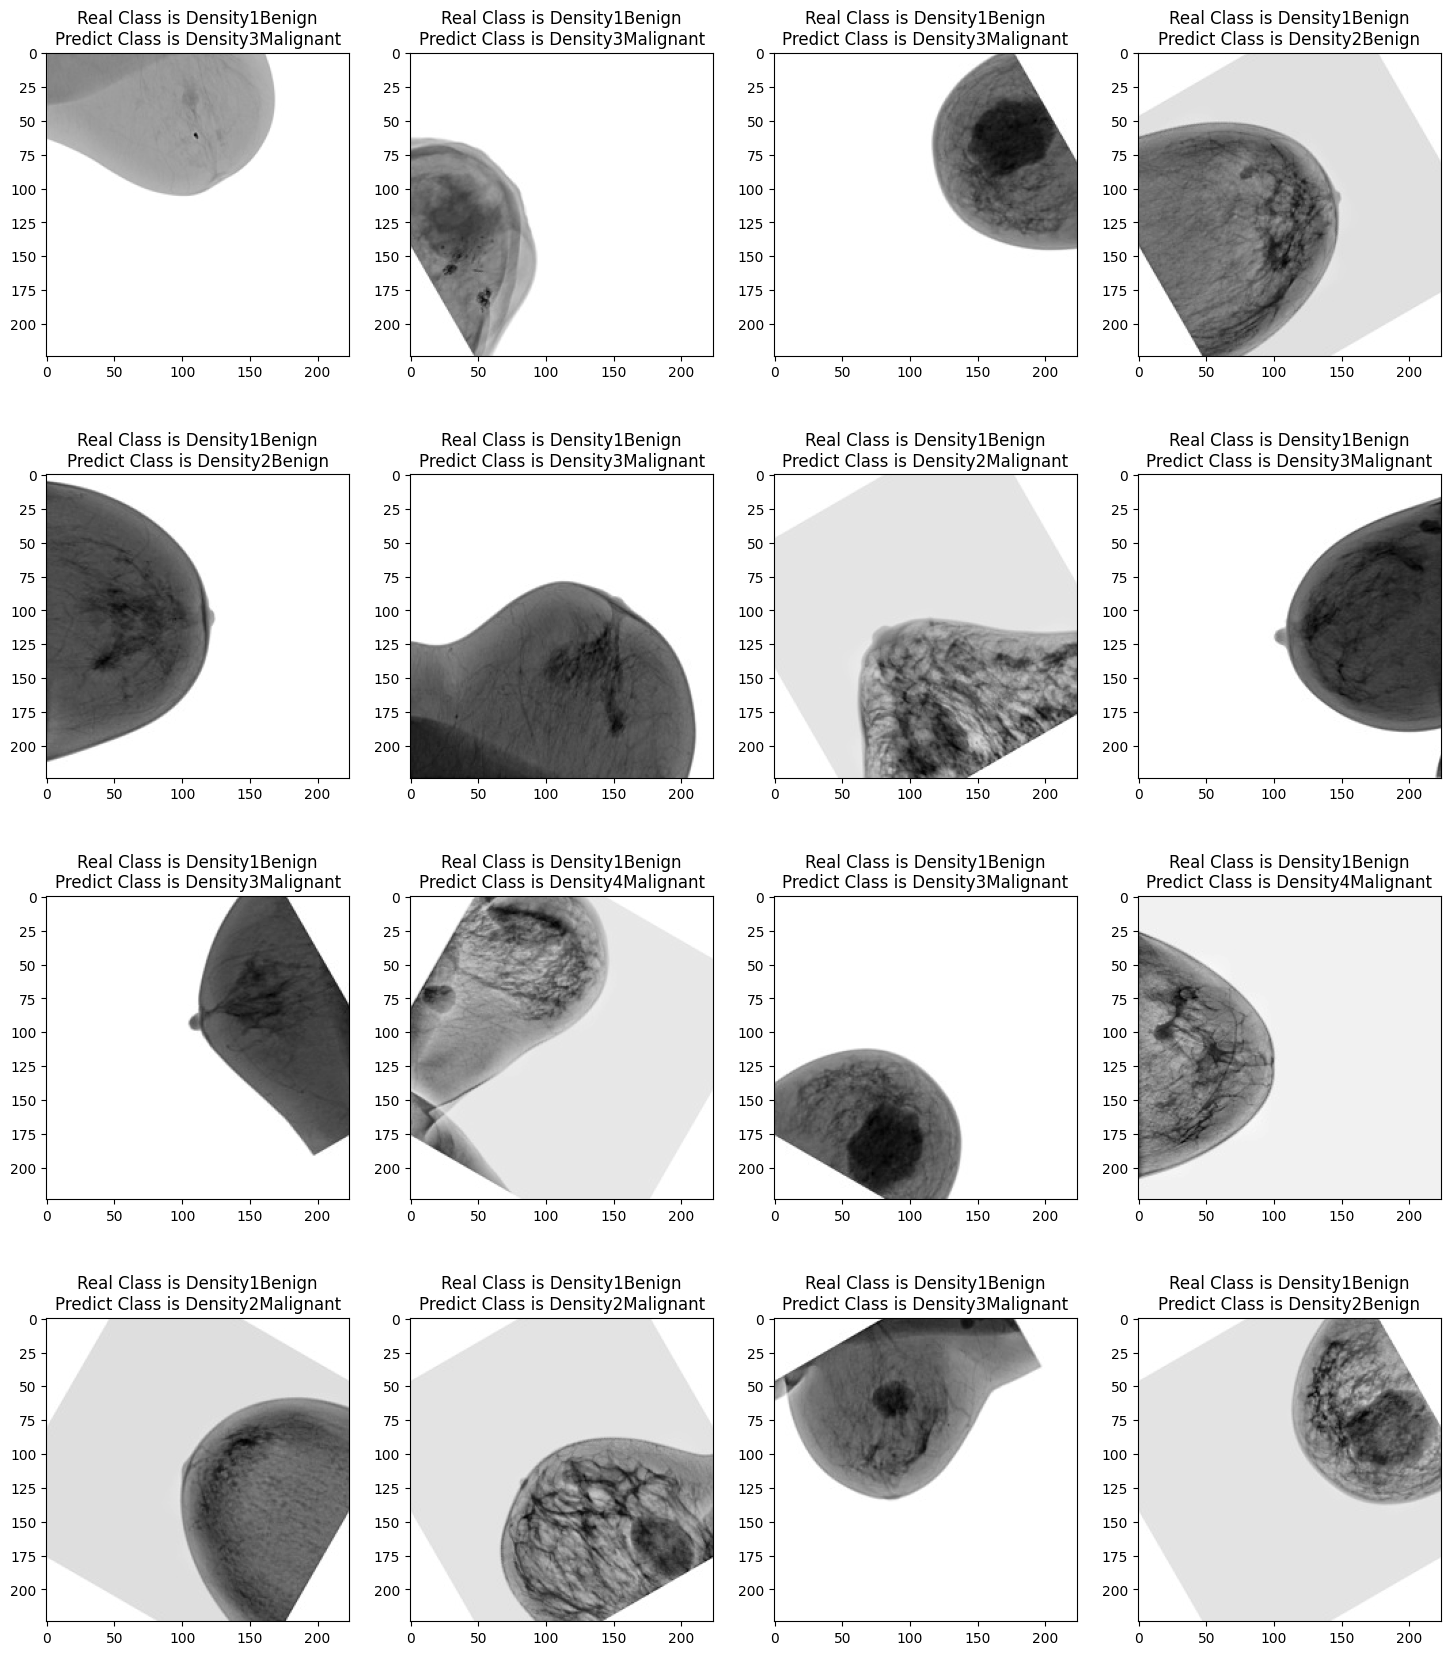